The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
-3.141592653589793 3.141592414089758


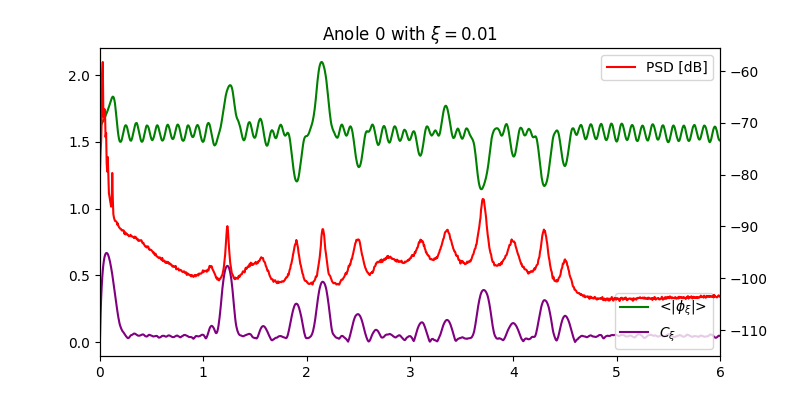

In [5]:
import os
os.chdir("paper_analysis")
import phaseco as pc
from N_xi_fit_funcs import *

from pathlib import Path
cwd = Path.cwd()
os.chdir(cwd.parent)


import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload
%matplotlib widget

all_species = ["Human", "Anole", "Owl", "Tokay"]
speciess = ["Anole"]

for win_meth in [
    # {"method": "zeta", "zeta": 0.01, "win_type": "hann"},
    {"method": "rho", "rho": 0.7},
    # {"method": "zeta", "zeta": 0.01, "win_type": "boxcar"},
    # {"method": "static", "win_type": "hann"},
]:
    for pw in [False]:
        for species in speciess:
            for wf_idx in range(1):
                "Get waveform"
                wf, wf_fn, fs, good_peak_freqs, bad_peak_freqs = get_wf(
                    species=species,
                    wf_idx=wf_idx,
                )

                "PARAMETERS"
                # WF pre-processing parameters
                filter = {
                    "type": "kaiser",
                    # "cf": 300,
                    "df": 50,
                    "rip": 100,
                }  # cutoff freq (HPF if one value, BPF if two), transition band width, and max allowed ripple (in dB)
                wf_len_s = 60  # Will crop waveform to this length (in seconds)
                scale = True  # Scale the waveform for dB SPL (shouldn't have an effect outisde of vertical shift on PSD; 
                # only actually scales if we know the right scaling constant, which is only Anoles and Humans)

                # Species parameters
                max_khzs = {
                    "Anole": 6,
                    "Tokay": 6,
                    "Human": 10,
                    "V Sim Human": 10,
                    "Owl": 12,
                }
                max_khz = max_khzs[species]

                # Coherence Parameters
                hop_s = 0.01
                xi_s = 0.01
                tau_s = 2**13 / 44100  # Everyone uses the same tau_s
                
                tau = round(
                    tau_s * fs
                )  # This is just 2**13 for (power of 2 = maximally efficient FFT), except for owls where fs!=44100
                hop = round(hop_s*fs)
                xi = round(xi_s*fs)

                "XI"
                # GET AC
                ac_dict = pc.get_autocoherence(wf, fs, xi, pw, tau, hop=hop, win_meth=win_meth, ref_type="next_seg", return_avg_abs_pd=True, return_dict=True)
                f, ac, avg_abs_pd = ac_dict['f'], ac_dict['autocoherence'], ac_dict['avg_abs_pd']
                f, psd = pc.get_welch(wf, fs, tau)

                # PLOT <|phi|>
                plt.figure(figsize=(8, 4))
                plt.title(rf"{species} {wf_idx} with $\xi={xi_s}$")
                plt.plot(f/1000, avg_abs_pd, label=r"<|$\phi_\xi$|>", color='green')
                plt.plot(f/1000, ac, label=rf'$C_\xi$', color='purple')
                plt.xlim(0, max_khz)
                plt.legend(loc='lower right')
                _ = plt.twinx()
                plt.plot(f/1000, 10*np.log10(psd), label='PSD [dB]', color='red')
                plt.legend(loc = 'upper right')
                plt.xlim(0, max_khz)
                plt.show()

                # "OMEGA"
                # # GET AC
                # ac_dict = pc.get_autocoherence(wf, fs, xi, pw, tau, hop=hop, win_meth=win_meth, ref_type="next_seg", return_avg_abs_pd=True, return_dict=True)
                # f, ac, avg_abs_pd = ac_dict['f'], ac_dict['autocoherence'], ac_dict['avg_abs_pd']
                # f, psd = pc.get_welch(wf, fs, tau)

                # # PLOT <|phi|>
                # plt.figure(figsize=(8, 4))
                # plt.title(rf"{species} {wf_idx} with $\xi={xi_s}$")
                # plt.plot(f/1000, avg_abs_pd, label=r"<|$\phi_\xi$|>", color='green')
                # plt.plot(f/1000, ac, label=rf'$C_\xi$', color='purple')
                # plt.xlim(0, max_khz)
                # plt.legend(loc='lower right')
                # _ = plt.twinx()
                # plt.plot(f/1000, 10*np.log10(psd), label='PSD [dB]', color='red')
                # plt.legend(loc = 'upper right')
                # plt.xlim(0, max_khz)
                # plt.show()

                
